In [1]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')
    import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

In [3]:
df = pd.read_csv('../dataset/JINDALSTEL.NS.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,10-10-2019,96.900002,97.849998,94.599998,95.650002,95.650002,17559085
1,11-10-2019,96.650002,100.250000,95.250000,97.449997,97.449997,26700762
2,14-10-2019,99.550003,102.699997,98.750000,99.500000,99.500000,21326087
3,15-10-2019,99.550003,104.949997,96.250000,103.099998,103.099998,33002841
4,16-10-2019,103.500000,104.199997,101.250000,102.400002,102.400002,15985718


In [4]:
minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.000000
1,0.017621
2,0.037690
3,0.072932
4,0.066079


## Forecast

This example is using model 1.lstm, if you want to use another model, need to tweak a little bit, but I believe it is not that hard.

I want to forecast 30 days ahead! So just change `test_size` to forecast `t + N` ahead.

Also, I want to simulate 10 times, 10 variances of forecasted patterns. Just change `simulation_size`.

In [5]:
simulation_size = 15
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 400
dropout_rate = 0.8
test_size = 30
learning_rate = 0.01

df_train = df_log
df.shape, df_train.shape

((103, 7), (103, 1))

In [6]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )
        
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [7]:
def forecast():
    tf.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )        
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))
    
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    init_value = last_state
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.4)
    
    return deep_future

In [8]:
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results.append(forecast())

W0310 18:31:51.765139 10756 deprecation.py:323] From <ipython-input-6-d01d21f09afe>:12: LSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0310 18:31:51.769098 10756 rnn_cell_impl.py:894] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001EF836B3988>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0310 18:31:51.773092 10756 deprecation.py:323] From <ipython-input-6-d01d21f09afe>:16: MultiRNNCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
W0310 18:31:51.773092 10756 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in Te

simulation 1


W0310 18:32:02.025878 10756 deprecation.py:323] From <ipython-input-6-d01d21f09afe>:27: dynamic_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
W0310 18:32:02.073814 10756 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\ops\rnn_cell_impl.py:958: Layer.add_variable (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.add_weight` method instead.
W0310 18:32:02.089793 10756 deprecation.py:506] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\ops\rnn_cell_impl.py:962: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to t

simulation 2


train loop: 100%|████████████████████████████████████████████| 400/400 [00:40<00:00,  9.82it/s, acc=95.7, cost=0.00508]
W0310 18:33:25.545807 10756 rnn_cell_impl.py:894] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001EF85B32D08>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 3


train loop: 100%|████████████████████████████████████████████| 400/400 [01:05<00:00,  6.14it/s, acc=96.2, cost=0.00371]
W0310 18:34:31.258214 10756 rnn_cell_impl.py:894] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001EF86DF1708>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 4


train loop: 100%|████████████████████████████████████████████| 400/400 [00:40<00:00,  9.96it/s, acc=95.7, cost=0.00579]
W0310 18:35:12.087403 10756 rnn_cell_impl.py:894] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001EF87FA7B08>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 5


train loop: 100%|████████████████████████████████████████████| 400/400 [00:40<00:00,  9.90it/s, acc=95.2, cost=0.00615]
W0310 18:35:52.952718 10756 rnn_cell_impl.py:894] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001EF87F80188>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 6


train loop: 100%|██████████████████████████████████████████████| 400/400 [00:39<00:00, 10.20it/s, acc=96, cost=0.00456]
W0310 18:36:32.646284 10756 rnn_cell_impl.py:894] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001EF8932CD88>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 7


train loop: 100%|████████████████████████████████████████████| 400/400 [00:38<00:00, 10.47it/s, acc=95.6, cost=0.00521]
W0310 18:37:11.427291 10756 rnn_cell_impl.py:894] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001EF89333F08>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 8


train loop: 100%|████████████████████████████████████████████| 400/400 [00:35<00:00, 11.34it/s, acc=95.9, cost=0.00478]
W0310 18:37:47.187049 10756 rnn_cell_impl.py:894] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001EF8B4FFE08>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 9


train loop: 100%|██████████████████████████████████████████████| 400/400 [00:37<00:00, 10.66it/s, acc=95, cost=0.00817]
W0310 18:38:25.640582 10756 rnn_cell_impl.py:894] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001EF8C9EDA48>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 10


train loop: 100%|████████████████████████████████████████████| 400/400 [00:35<00:00, 11.30it/s, acc=96.2, cost=0.00383]
W0310 18:39:01.601347 10756 rnn_cell_impl.py:894] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001EF8CA4D8C8>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 11


train loop: 100%|█████████████████████████████████████████████| 400/400 [00:35<00:00, 11.36it/s, acc=95.9, cost=0.0045]
W0310 18:39:37.390673 10756 rnn_cell_impl.py:894] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001EF8DA5AB08>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 12


train loop: 100%|█████████████████████████████████████████████| 400/400 [00:37<00:00, 10.55it/s, acc=95.7, cost=0.0048]
W0310 18:40:15.937207 10756 rnn_cell_impl.py:894] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001EF8DC0B548>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 13


train loop: 100%|████████████████████████████████████████████| 400/400 [00:38<00:00, 10.49it/s, acc=94.3, cost=0.00925]
W0310 18:40:54.526848 10756 rnn_cell_impl.py:894] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001EF8C8DC708>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 14


train loop: 100%|███████████████████████████████████████████████| 400/400 [00:39<00:00, 10.03it/s, acc=96, cost=0.0043]
W0310 18:41:34.932828 10756 rnn_cell_impl.py:894] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001EF8FFD67C8>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 15


train loop: 100%|████████████████████████████████████████████| 400/400 [00:36<00:00, 10.95it/s, acc=95.7, cost=0.00507]


In [9]:
date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
for i in range(test_size):
    date_ori.append(date_ori[-1] + timedelta(days = 1))
date_ori = pd.Series(date_ori).dt.strftime(date_format = '%Y-%m-%d').tolist()
date_ori[-5:]

['2020-09-29', '2020-09-30', '2020-10-01', '2020-10-02', '2020-10-03']

## Sanity check

Some of our models might not have stable gradient, so forecasted trend might really hangwired. You can use many methods to filter out unstable models.

This method is very simple,
1. If one of element in forecasted trend lower than min(original trend).
2. If one of element in forecasted trend bigger than max(original trend) * 2.

If both are true, reject that trend.

In [10]:
accepted_results = []
for r in results:
    if (np.array(r[-test_size:]) < np.min(df['Close'])).sum() == 0 and \
    (np.array(r[-test_size:]) > np.max(df['Close']) * 2).sum() == 0:
        accepted_results.append(r)
len(accepted_results)

13

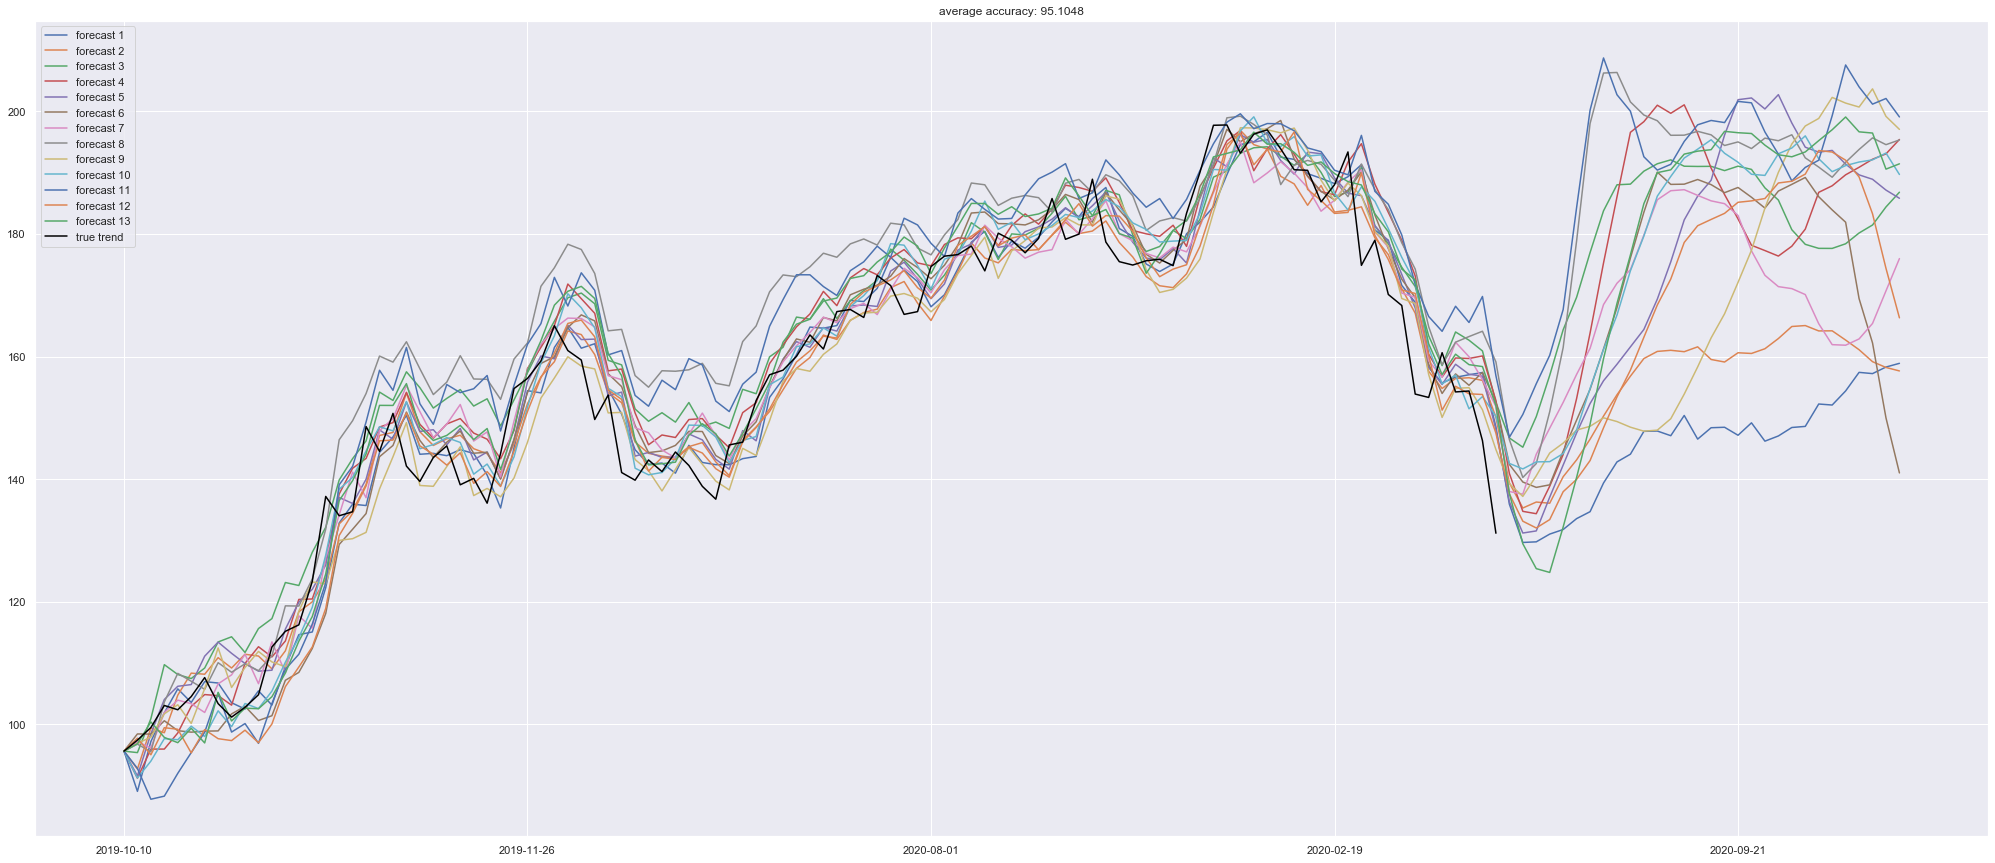

In [11]:
accuracies = [calculate_accuracy(df['Close'].values, r[:-test_size]) for r in accepted_results]

plt.figure(figsize = (35, 15))
for no, r in enumerate(accepted_results):
    plt.plot(r, label = 'forecast %d'%(no + 1))
plt.plot(df['Close'], label = 'true trend', c = 'black')
plt.legend()
plt.title('average accuracy: %.4f'%(np.mean(accuracies)))

x_range_future = np.arange(len(results[0]))
plt.xticks(x_range_future[::30], date_ori[::30])

plt.show()